In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

from glob import glob
from PIL import Image

from sklearn.feature_selection import f_classif, f_regression
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings(action='ignore')

# 한글 폰트 사용을 위해서 세팅
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## Data Load

In [2]:
train = pd.read_csv('./train.csv')
print(train.shape)
train.head(5)

(1000, 28)


,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [3]:
test = pd.read_csv("test.csv")

print(test.shape)
test.head(3)

(250, 26)


,ID,img_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0011,./test_imgs/BC_01_0011.png,55,2015-11-17,2,2,1,23.0,2.0,2.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,BC_01_0220,./test_imgs/BC_01_0220.png,43,2020-06-09,4,2,1,13.0,3.0,2.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,BC_01_0233,./test_imgs/BC_01_0233.png,76,2020-05-14,1,1,1,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN


In [4]:
submission = pd.read_csv("sample_submission.csv")

print(submission.shape)
submission.head(3)

(250, 2)


,ID,N_category
0,BC_01_0011,0
1,BC_01_0220,0
2,BC_01_0233,0


In [5]:
img_arrays = []

for fn in train["img_path"]:
    img = Image.open(fn)
    img_resize = img.resize((int(img.width / 4), int(img.height / 4)))
    img_arrays.append(np.array(img_resize))

train_img = np.array(img_arrays)    

In [6]:
len(train_img)

1000

In [7]:
img_arrays = []

for fn in test["img_path"]:
    img = Image.open(fn)
    img_resize = img.resize((int(img.width / 4), int(img.height / 4)))
    img_arrays.append(np.array(img_resize))


test_img = np.array(img_arrays)    

In [8]:
len(test_img)

250

## Simple Informations

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   object 
 1   img_path           1000 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1000 non-null   int64  
 4   수술연월일              1000 non-null   object 
 5   진단명                1000 non-null   int64  
 6   암의 위치              1000 non-null   int64  
 7   암의 개수              1000 non-null   int64  
 8   암의 장경              931 non-null    float64
 9   NG                 949 non-null    float64
 10  HG                 914 non-null    float64
 11  HG_score_1         908 non-null    float64
 12  HG_score_2         908 non-null    float64
 13  HG_score_3         911 non-null    float64
 14  DCIS_or_LCIS_여부    1000 non-null   int64  
 15  DCIS_or_LCIS_type  126 non-null    float64
 16  T_category         996 no

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 250 non-null    object 
 1   img_path           250 non-null    object 
 2   나이                 250 non-null    int64  
 3   수술연월일              250 non-null    object 
 4   진단명                250 non-null    int64  
 5   암의 위치              250 non-null    int64  
 6   암의 개수              250 non-null    int64  
 7   암의 장경              237 non-null    float64
 8   NG                 235 non-null    float64
 9   HG                 234 non-null    float64
 10  HG_score_1         232 non-null    float64
 11  HG_score_2         232 non-null    float64
 12  HG_score_3         232 non-null    float64
 13  DCIS_or_LCIS_여부    250 non-null    int64  
 14  DCIS_or_LCIS_type  31 non-null     float64
 15  T_category         249 non-null    float64
 16  ER                 250 non

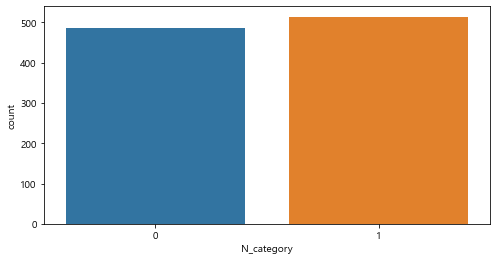

1    514
0    486
Name: N_category, dtype: int64
1    0.514
0    0.486
Name: N_category, dtype: float64


In [11]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='N_category')
plt.show()

cnt = train["N_category"].value_counts()
rate = train["N_category"].value_counts(normalize=True)

print(cnt)
print(rate)

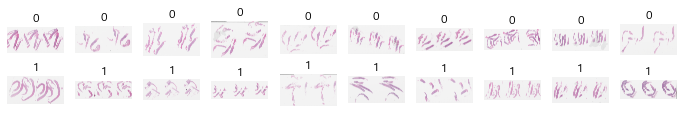

In [12]:
plt.figure(figsize=(12,10))

for n in range(0,11):  
    train_idx = train[train["N_category"] == n].tail(10).index
    for i, m in enumerate(train_idx):
        img = train_img[m]
        plt.subplot(11, 10, (n*10)+(i+1)) 
        plt.imshow(img, cmap=plt.cm.binary)
        plt.axis("off")
        plt.title(train.loc[m, "N_category"])

## Correlation

<AxesSubplot:>

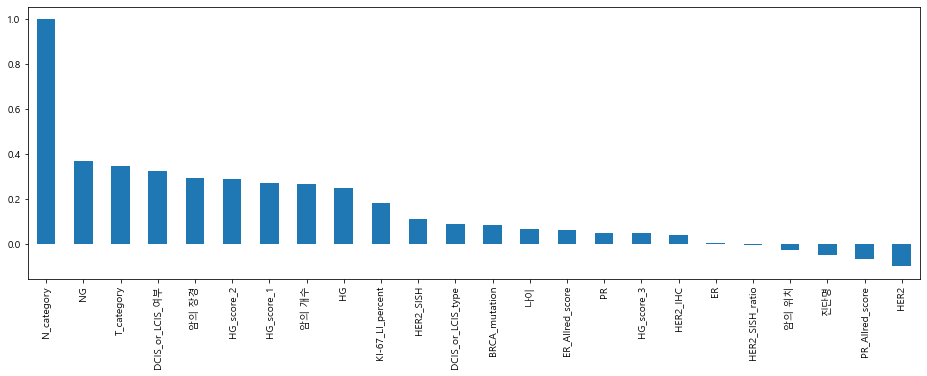

In [13]:
# Pearson Correlation
corr_matrix = train.corr()

corr_ = corr_matrix["N_category"].sort_values(ascending=False)
corr_.plot.bar(figsize = (16, 5))

In [14]:
corr_

N_category           1.000000
NG                   0.371070
T_category           0.348237
DCIS_or_LCIS_여부      0.324415
암의 장경                0.292102
HG_score_2           0.287524
HG_score_1           0.272786
암의 개수                0.268900
HG                   0.247525
KI-67_LI_percent     0.184746
HER2_SISH            0.113766
DCIS_or_LCIS_type    0.090921
BRCA_mutation        0.085749
나이                   0.069017
ER_Allred_score      0.064873
PR                   0.050941
HG_score_3           0.047555
HER2_IHC             0.042458
ER                   0.003192
HER2_SISH_ratio     -0.002703
암의 위치               -0.026330
진단명                 -0.049135
PR_Allred_score     -0.066670
HER2                -0.098551
Name: N_category, dtype: float64

<AxesSubplot:>

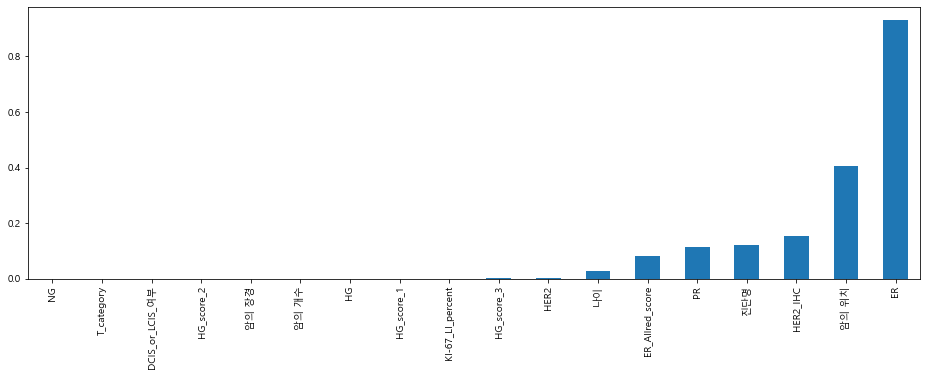

In [15]:
# Anova Correlation
t = train.copy()

t_label = t['N_category']
t_data = t.drop(['N_category'], axis=1)

t_data = t_data.select_dtypes(exclude=['object']) # object dtype의 열 제거

# 결측치가 300개가 넘어가는 열 제거
t_data = t_data.drop(['DCIS_or_LCIS_type', 'PR_Allred_score', 'HER2_SISH', 'HER2_SISH_ratio', 'BRCA_mutation'], axis=1)

# 결측치가 300개가 넘지 않는 컬럼 -> 중간값으로 메꾸기
imputer = SimpleImputer(strategy="median")
imputer.fit(t_data)
X = imputer.transform(t_data)
t_data = pd.DataFrame(X, columns=t_data.columns, index=t_data.index)


sel = f_classif(t_data, t_label)

p_values = pd.Series(sel[1])
p_values.index = t_data.columns
p_values.sort_values(ascending = True, inplace = True)

p_values.plot.bar(figsize = (16, 5))

In [16]:
p_values

NG                  1.214775e-32
T_category          1.882693e-29
DCIS_or_LCIS_여부     6.134950e-26
HG_score_2          8.430616e-21
암의 장경               1.494569e-20
암의 개수               5.033841e-18
HG                  7.956039e-13
HG_score_1          9.907604e-11
KI-67_LI_percent    1.841873e-09
HG_score_3          3.938858e-03
HER2                4.202555e-03
나이                  2.908133e-02
ER_Allred_score     8.299414e-02
PR                  1.131264e-01
진단명                 1.204748e-01
HER2_IHC            1.518864e-01
암의 위치               4.055593e-01
ER                  9.318402e-01
dtype: float64

In [24]:
p_values5 = p_values[p_values<0.05]

In [26]:
corr_positive = corr_[corr_>0]

In [27]:
selected_feature = p_values5.index & corr_positive.index
selected_feature

Index(['NG', 'T_category', 'DCIS_or_LCIS_여부', 'HG_score_2', '암의 장경', '암의 개수',
       'HG', 'HG_score_1', 'KI-67_LI_percent', 'HG_score_3', '나이'],
      dtype='object')

In [28]:
t_data = t_data[selected_feature]

In [29]:
t_data

,NG,T_category,DCIS_or_LCIS_여부,HG_score_2,암의 장경,암의 개수,HG,HG_score_1,KI-67_LI_percent,HG_score_3,나이
0,2.0,1.0,2.0,2.0,19.0,1.0,1.0,2.0,12.0,1.0,63.0
1,3.0,2.0,0.0,3.0,22.0,1.0,3.0,3.0,70.0,3.0,51.0
2,2.0,0.0,1.0,2.0,17.0,1.0,2.0,3.0,7.0,1.0,37.0
3,3.0,0.0,1.0,3.0,0.0,1.0,3.0,3.0,1.0,2.0,54.0
4,2.0,1.0,2.0,2.0,8.0,1.0,2.0,3.0,8.0,1.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,2.0,0.0,1.0,25.0,1.0,1.0,2.0,10.0,1.0,65.0
996,1.0,1.0,0.0,1.0,7.0,1.0,1.0,1.0,10.0,1.0,48.0
997,1.0,1.0,0.0,1.0,15.0,1.0,1.0,2.0,10.0,2.0,64.0
998,1.0,1.0,0.0,2.0,7.0,1.0,1.0,1.0,10.0,1.0,50.0


In [54]:
t_data.columns

Index(['NG', 'T_category', 'DCIS_or_LCIS_여부', 'HG_score_2', '암의 장경', '암의 개수',
       'HG', 'HG_score_1', 'KI-67_LI_percent', 'HG_score_3', '나이'],
      dtype='object')

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


In [38]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    t_data, 
                                                    t_label, 
                                                    test_size=0.2, 
                                                    random_state=41
                                                )

In [39]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))

    else: 
        print(col)
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))


NG
T_category
DCIS_or_LCIS_여부
HG_score_2
암의 개수
HG
HG_score_1
HG_score_3


In [58]:
clf = RandomForestClassifier(n_estimators=400, random_state=41, n_jobs = -1, oob_score=True)
clf.fit(train_df, train_labels) # scailing on : x_train_scaleed, off : x_train
y_pred = clf.predict(val_df) # scailing on : x_test_scaled, off : x_test
print('Accuracy: ', accuracy_score(val_labels, y_pred))
print('oob_score: ', clf.oob_score_)

Accuracy:  0.735
oob_score:  0.7425


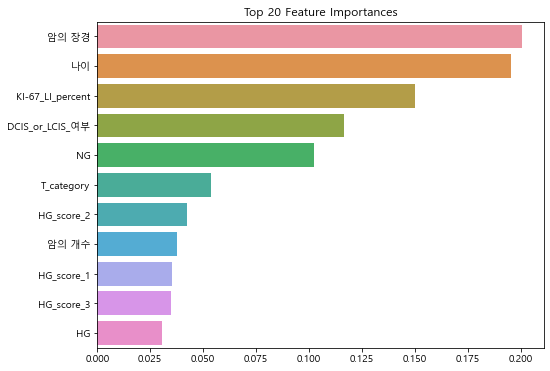

                precision    recall  f1-score   support

Non-transition       0.70      0.75      0.72       100
    Transition       0.73      0.68      0.70       100

      accuracy                           0.71       200
     macro avg       0.72      0.72      0.71       200
  weighted avg       0.72      0.71      0.71       200

tn : 75  fn : 32 

fp : 25  tp : 68


In [50]:
rdf_importances_values = clf.feature_importances_
rdf_importances = pd.Series(rdf_importances_values, index = train_df.columns)
rdf_top20 = rdf_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=rdf_top20, y=rdf_top20.index)
plt.show()

print(classification_report(val_labels, y_pred, target_names=['Non-transition', 'Transition']))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(val_labels, y_pred).ravel()
print("tn : %d  fn : %d \n"% (tn, fn))
print("fp : %d  tp : %d"% (fp, tp))

In [73]:
poly_svm = SVC(kernel="poly", degree=3, coef0=1, C=0.01, probability=True)
poly_svm.fit(train_df, train_labels)
y_pred = poly_svm.predict(val_df) # scailing on : x_test_scaled, off : x_test
print('Accuracy: ', accuracy_score(val_labels, y_pred))

Accuracy:  0.72


In [74]:
print(classification_report(val_labels, y_pred, target_names=['Non-transition', 'Transition']))

tn, fp, fn, tp = confusion_matrix(val_labels, y_pred).ravel()
print("tn : %d  fn : %d \n"% (tn, fn))
print("fp : %d  tp : %d"% (fp, tp))

                precision    recall  f1-score   support

Non-transition       0.68      0.82      0.75       100
    Transition       0.78      0.62      0.69       100

      accuracy                           0.72       200
     macro avg       0.73      0.72      0.72       200
  weighted avg       0.73      0.72      0.72       200

tn : 82  fn : 38 

fp : 18  tp : 62


In [64]:
gb_clf = GradientBoostingClassifier(n_estimators=300, random_state=127, learning_rate=0.01)
gb_clf.fit(train_df, train_labels) # scailing on : x_train_scaleed, off : x_train
y_pred = gb_clf.predict(val_df) # scailing on : x_test_scaled, off : x_test
print('Accuracy: ', accuracy_score(val_labels, y_pred))

Accuracy:  0.735


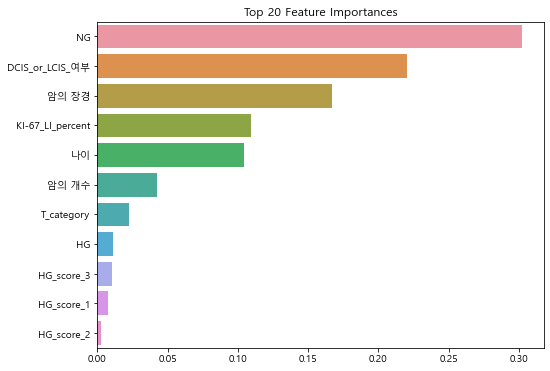

                precision    recall  f1-score   support

Non-transition       0.71      0.75      0.73       100
    Transition       0.73      0.69      0.71       100

      accuracy                           0.72       200
     macro avg       0.72      0.72      0.72       200
  weighted avg       0.72      0.72      0.72       200

tn : 75  fn : 31 

fp : 25  tp : 69


In [53]:
rdf_importances_values = gb_clf.feature_importances_
rdf_importances = pd.Series(rdf_importances_values, index = train_df.columns)
rdf_top20 = rdf_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=rdf_top20, y=rdf_top20.index)
plt.show()

print(classification_report(val_labels, y_pred, target_names=['Non-transition', 'Transition']))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(val_labels, y_pred).ravel()
print("tn : %d  fn : %d \n"% (tn, fn))
print("fp : %d  tp : %d"% (fp, tp))